In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels



In [174]:
from rkhs import compute_shifted_coverage, compute_adaptive_threshold

In [54]:
def generate_cqr_data():
    # number of training examples
    n_train = 2000
    # number of test examples (to evaluate average coverage and length)
    n_test = 5000

    def f(x):
        ''' Construct data (1D example)
        '''
        ax = 0*x
        for i in range(len(x)):
            ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
            ax[i] += 25*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
        return ax.astype(np.float32)

    # training features
    x_train = np.random.uniform(0, 5.0, size=n_train).astype(np.float32)

    # test features
    x_test = np.random.uniform(0, 5.0, size=n_test).astype(np.float32)

    # generate labels
    y_train = f(x_train)
    y_test = f(x_test)

    # reshape the features
    x_train = np.reshape(x_train,(n_train,1))
    x_test = np.reshape(x_test,(n_test,1))
    
    calibration_set_size = 1000
    train_set_size = len(y_train) - calibration_set_size
    x_train_final = x_train[ : train_set_size]
    x_calib = x_train[train_set_size : ]
    y_train_final = y_train[ : train_set_size]
    y_calib = y_train[train_set_size : ]
    
    return x_train_final, y_train_final, x_calib, y_calib, x_test, y_test

In [208]:
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data()

reg = LinearRegression().fit(x_train_final, y_train_final)
scores_calib = np.abs(reg.predict(x_calib) - y_calib)
scores_test = np.abs(reg.predict(x_test) - y_test)

def run_synthetic_trial(reg, alpha, radius, gamma, n_test, shift_loc):
    _, _, x_calib, y_calib, x_test, y_test = generate_cqr_data()

    scores_calib = np.abs(reg.predict(x_calib) - y_calib)
    scores_test = np.abs(reg.predict(x_test) - y_test)
    
    idx = np.argmin(np.abs(x_calib - shift_loc))
    g_weights = np.zeros((len(x_calib) + 1,))
    g_weights[idx] = 1
    
    est_coverage, weighted_coverage, thresholds = compute_shifted_coverage(
        scores_test,
        scores_calib,
        x_calib,
        x_test[0:n_test,],
        g_weights,
        kernel="rbf",
        alpha=alpha,
        radius=radius,
        gamma=gamma
    )
    
    return est_coverage, weighted_coverage

n_trials = 10
alpha = 0.9
radius = 1
n_test = 200
gamma = 2
shift_locs = [0.5, 1.4, 2.5, 3.5, 4.5]

df = pd.DataFrame()

for shift_loc in shift_locs:
    est_coverages = []
    emp_coverages = []
    for i in range(n_trials):
        est_cov, emp_cov = run_synthetic_trial(reg, alpha, radius, gamma, n_test, shift_loc)
        est_coverages.append(est_cov)
        emp_coverages.append(emp_cov)
        print(f"Trial {i}: {est_cov}, {emp_cov}")
    a_df = pd.DataFrame({'empirical coverage' : emp_coverages, 'estimated coverage': est_coverages})
    a_df['shift_loc'] = shift_loc
    df = pd.concat([df, a_df], axis=0)

100%|███████████████████████████████████████████████████████████████████| 200/200 [02:08<00:00,  1.56it/s]


Trial 0: 0.9104109156261236, 0.8881705429022134


 64%|███████████████████████████████████████████▏                       | 129/200 [01:25<00:46,  1.52it/s]


KeyboardInterrupt: 

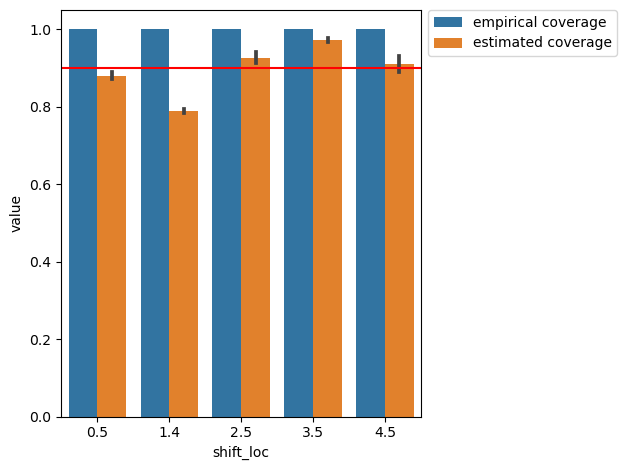

In [207]:
import seaborn as sns
import pandas as pd

fig = sns.barplot(
    pd.melt(df, id_vars=['shift_loc'], value_vars=['empirical coverage', 'estimated coverage']), 
    x='shift_loc', 
    y='value',
    hue='variable')
fig.axhline(alpha, color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

100%|███████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]

0.8998966949157221 0.8391796279611702


(-2.0, 6.0)

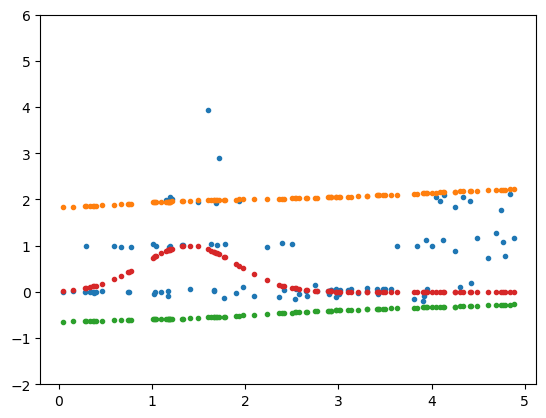

In [195]:
alpha = 0.9
radius = 1
n_test = 200
gamma = 2

n_test = 100

idx = np.argmin(np.abs(x_calib - 1.4))
g_weights = np.zeros((len(x_calib) + 1,))
g_weights[idx] = 1

K_fhat = rbf_kernel(
    X=x_test[0:n_test,:],
    Y=np.concatenate([x_calib, x_test[0,:].reshape(1,-1)], axis=0),
    gamma=gamma
)
    
est_coverage, weighted_coverage, thresholds = compute_shifted_coverage(
    scores_test,
    scores_calib,
    x_calib,
    x_test[0:n_test,:],
    g_weights,
    kernel="rbf",
    alpha=alpha,
    radius=radius,
    gamma=gamma
)
print(est_coverage, weighted_coverage)


plt.figure()
plt.plot(x_test[0:n_test], y_test[0:n_test], '.')
plt.plot(x_test[0:n_test], reg.predict(x_test[0:n_test]) + thresholds, '.', label='upper')
plt.plot(x_test[0:n_test], reg.predict(x_test[0:n_test]) - thresholds, '.', label='lower')
plt.plot(x_test[0:n_test], K_fhat @ g_weights, '.', label='shift')
plt.ylim(-2, 6)

(-2.0, 6.0)

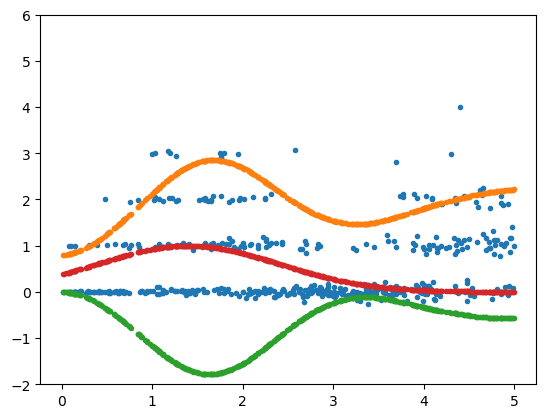

In [189]:
plt.figure()
plt.plot(x_test[0:n_test], y_test[0:n_test], '.')
plt.plot(x_test[0:n_test], reg.predict(x_test[0:n_test]) + thresholds, '.', label='upper')
plt.plot(x_test[0:n_test], reg.predict(x_test[0:n_test]) - thresholds, '.', label='lower')
plt.plot(x_test[0:n_test], K_fhat @ g_weights, '.', label='shift')
plt.ylim(-2, 6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


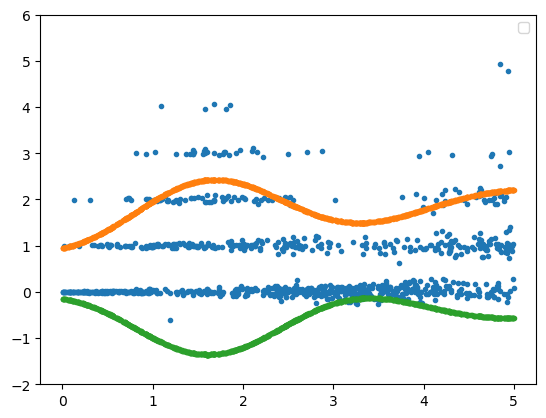

In [159]:
from rkhs import setup_cvx_primal, setup_cvx_dual
alpha = 0.9
radius = 200
gamma = 0.5

prob_1 = setup_cvx_problem(
    x_calib,
    scores_calib,
    kernel="rbf",
    gamma=gamma,
    alpha=alpha,
    radius=radius
)

K = rbf_kernel(
    X=np.concatenate([x_calib, x_test[0,:].reshape(1,-1)], axis=0),
    gamma=gamma
)

prob_2 = setup_cvx_dual(
    x_calib,
    scores_calib,
    kernel="rbf",
    gamma=gamma,
    alpha=alpha,
    radius=radius
)
f_hat = compute_adaptive_threshold(
    prob_2,
    scores_calib,
    x_calib,
    x_test[0,:],
    kernel="rbf",
    gamma=gamma
)

thresholds = f_hat['intercept'] + K @ f_hat['weights']

x_plot = np.concatenate([x_calib, x_test[0,:].reshape(1,-1)], axis=0)
plt.plot(x_calib, y_calib, '.')
plt.plot(x_plot, reg.predict(x_plot) + thresholds, '.')
plt.plot(x_plot, reg.predict(x_plot) - thresholds, '.')
plt.ylim(-2, 6)
